## Palo Alto

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv('EVChargingStationUsage.csv')

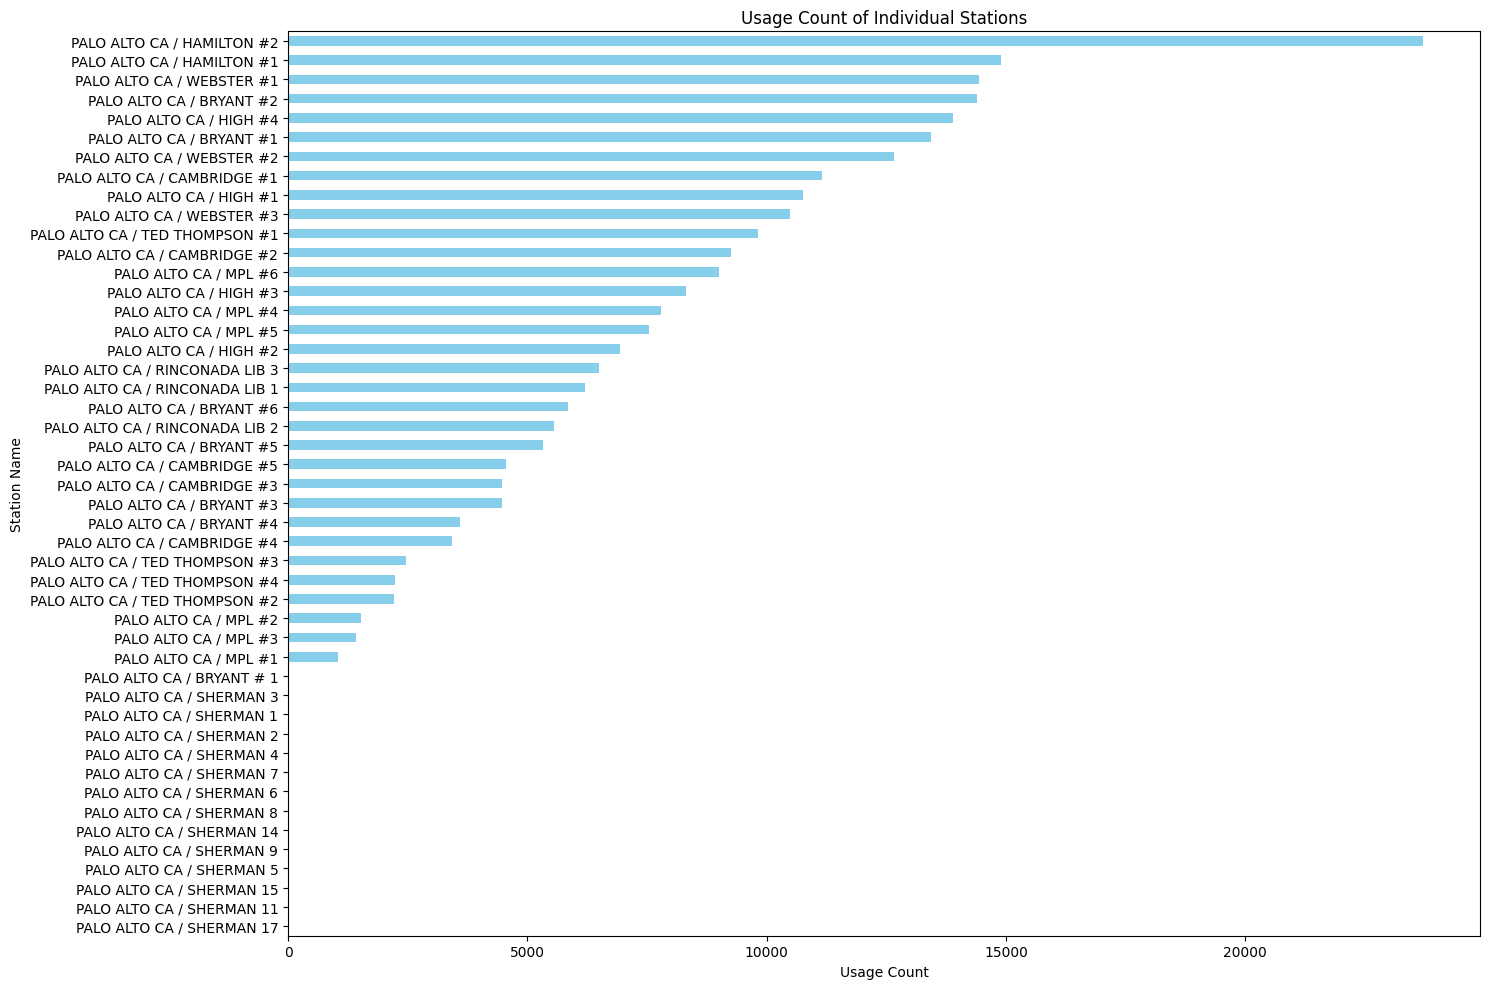

In [2]:
#occurrences of each unique station
station_counts = data['Station Name'].value_counts()
plt.figure(figsize=(15, 10))  
station_counts.plot(kind='barh', color='skyblue')  
plt.title('Usage Count of Individual Stations')
plt.xlabel('Usage Count')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()  
plt.tight_layout()  
plt.show()

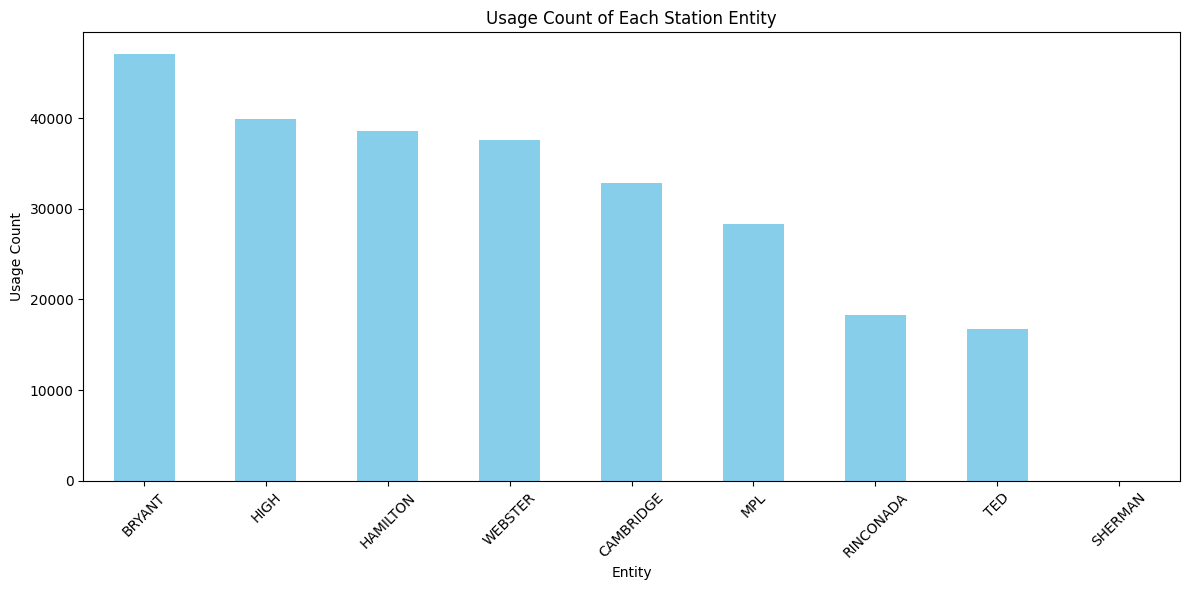

In [3]:
#function to extract the entity based on the first word following "PALO ALTO CA /"
def extract_entity(station_name):
    parts = station_name.split('/')
    if len(parts) > 1:
        # Take the part after "PALO ALTO CA /" and then take the first word
        return parts[1].strip().split(' ')[0]
    else:
        # If the station name does not follow the expected format, return the original
        return station_name

#function to create the 'Entity' column
data['Entity'] = data['Station Name'].apply(extract_entity)
#occurrences of each entity
entity_counts = data['Entity'].value_counts()

#plotting the usage count of each entity
plt.figure(figsize=(12, 6))
entity_counts.plot(kind='bar', color='skyblue')
plt.title('Usage Count of Each Station Entity')
plt.xlabel('Entity')
plt.ylabel('Usage Count')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

RMSE for PALO ALTO CA / HAMILTON Stations: 38.969570811499736
RMSE for PALO ALTO CA / HIGH Stations: 36.23864269239902
RMSE for PALO ALTO CA / BRYANT Stations: 28.884213151289615
RMSE for PALO ALTO CA / MPL Stations: 34.028344777455516
RMSE for RINCONADA LIB Stations: 42.61754665126634
RMSE for PALO ALTO CA / WEBSTER Stations: 48.69095467504165
RMSE for PALO ALTO CA / TED THOMPSON Stations: 72.37957518737232
RMSE for PALO ALTO CA / CAMBRIDGE Stations: 79.27997181578087


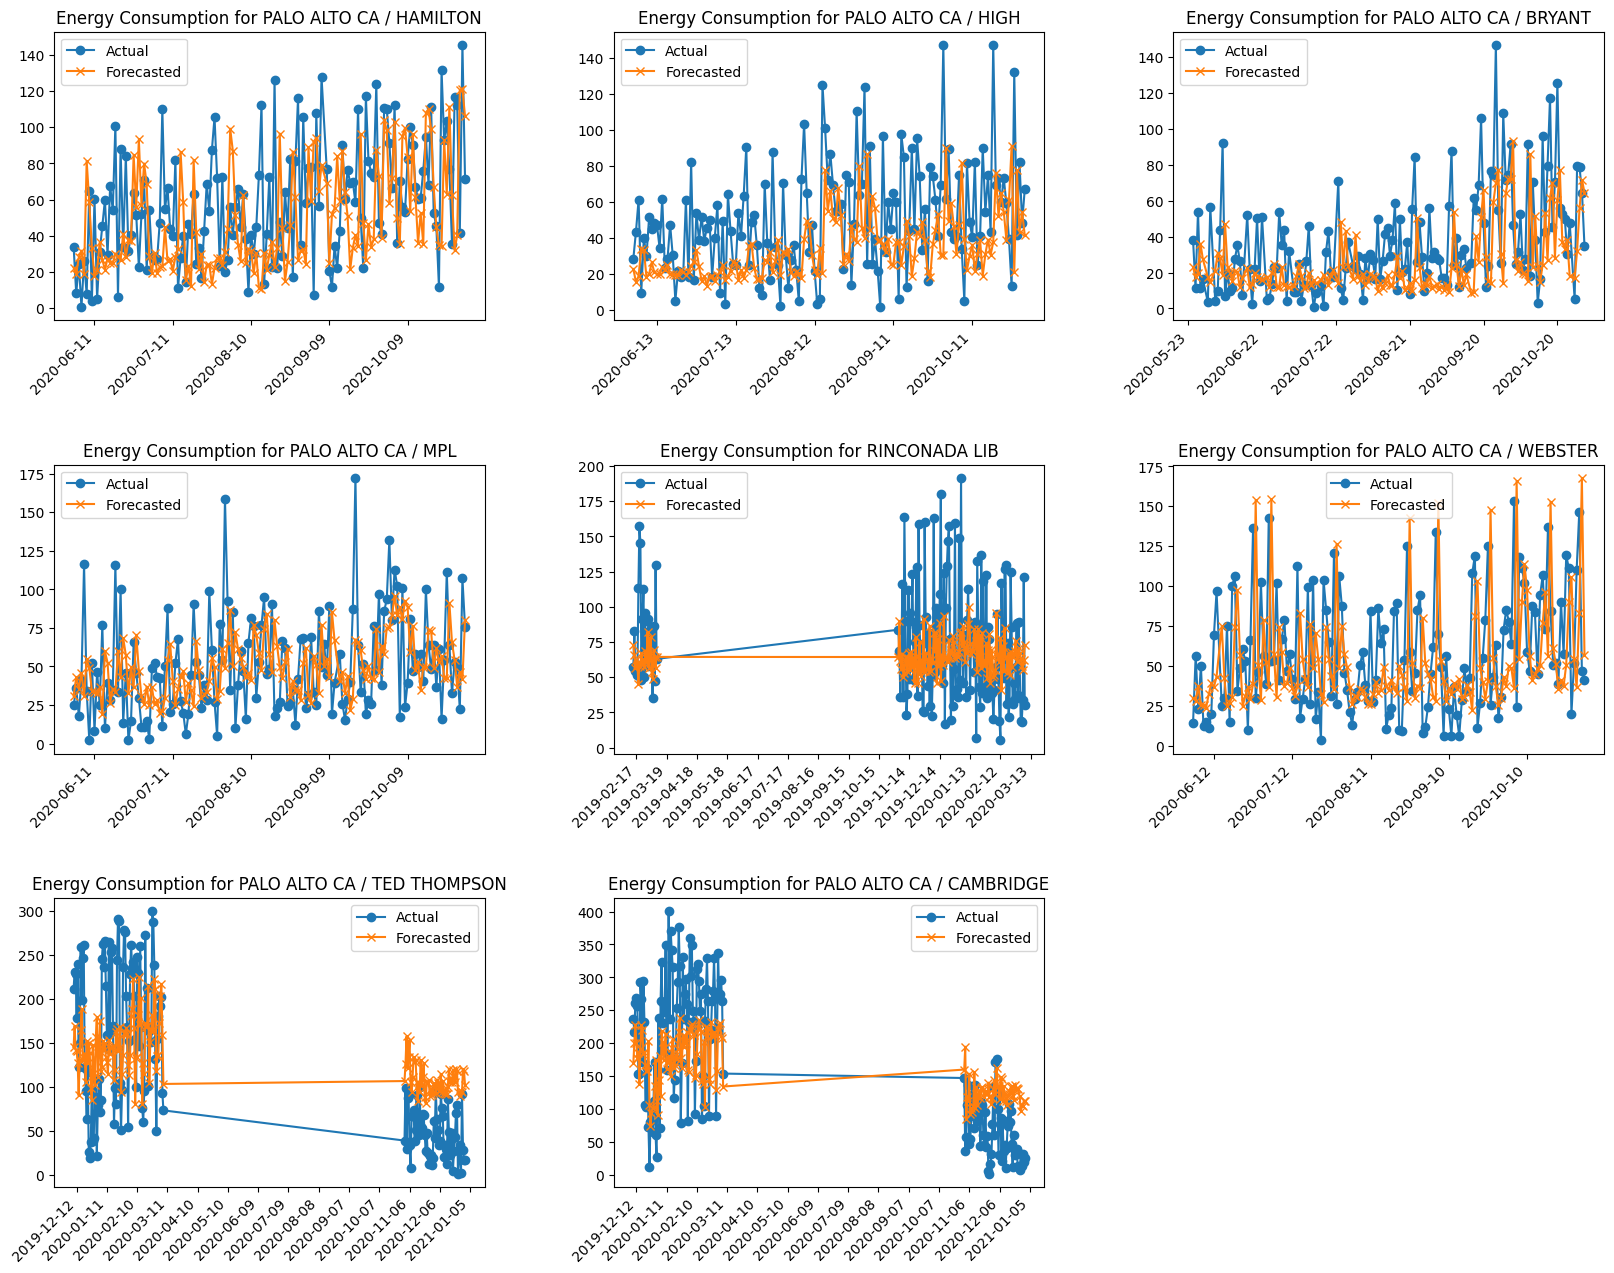

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Specify the days in one lag -----------------------------
lag_num= 30
#---------------------------------------------------------
# Function to create lagged features



def buildLaggedFeatures(s, lag=30, dropna=True):#lag=30-->30days ; lag=7-->1day; lag=1-->lag=1
    df = pd.concat([s.shift(i) for i in range(lag + 1)], axis=1)
    df.columns = ['lag_{}'.format(i) if i != 0 else s.name for i in range(lag + 1)]
    if dropna:
        df = df.dropna()
    return df

# Normalize station names
def normalize_station_name(name):
    name = name.upper()
    if "RINCONADA" in name:
        parts = name.split()
        new_parts = []
        for part in parts:
            if part.startswith('LIB') and len(parts) > parts.index(part) + 1 and parts[parts.index(part) + 1].isdigit():
                digit = parts.pop(parts.index(part) + 1)
                new_parts.append(part + ' #' + digit)
            else:
                new_parts.append(part)
        modified_name = ' '.join(new_parts)
        if 'RINCONADA LIB #' in modified_name:
            return 'RINCONADA LIB'
        return modified_name
    if "SHERMAN" in name:
        return None
    return name.split('#')[0].strip()

# Load data
data = pd.read_csv('EVChargingStationUsage.csv')

data['Normalized Station Name'] = data['Station Name'].apply(normalize_station_name)
data = data.dropna(subset=['Normalized Station Name'])

stations = data['Normalized Station Name'].unique()

# Set up the plot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Processing each normalized station group
for idx, station in enumerate(stations):
    if idx >= 9:
        break
    station_data = data[data['Normalized Station Name'] == station]
    station_data['Start DateTime'] = pd.to_datetime(station_data['Start Date'] + ' ' + station_data['Start Time Zone'], errors='coerce')
    station_data.dropna(subset=['Start DateTime'], inplace=True)
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy (kWh)'].sum()
    lagged_features = buildLaggedFeatures(daily_energy, lag=lag_num)
    if lag_num<=7:
        train_data = lagged_features.iloc[-(150+lag_num*6):-30] #Added lag_num*6 to ensure there is enough previous data for training
        test_data = lagged_features.iloc[-30:] #lag_num=7 --> lag=7days --> 30lags-last lag
    else: 
        train_data = lagged_features.iloc[-(lag_num*10):-lag_num*5] #Added lag_num*6 to ensure there is enough previous data for training + lag_num*7 for monthly prediciton.
        test_data = lagged_features.iloc[-lag_num*5:] # lag_num=30, lag=30dyas, 5*30days -->training data
    X_train = train_data.drop(columns=['Energy (kWh)'])
    y_train = train_data['Energy (kWh)']
    X_test = test_data.drop(columns=['Energy (kWh)'])
    y_test = test_data['Energy (kWh)']
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')
    ax = axes[idx]
    ax.plot(y_test.index, y_test, label='Actual', marker='o')
    ax.plot(y_test.index, y_pred, label='Forecasted', marker='x')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=lag_num))  # Set interval to 2 for every second day
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    ax.set_title(f'Energy Consumption for {station}')
    ax.legend()

# Hide any unused axes if there are less than 9 stations
for ax in axes[len(stations):]:
    ax.set_visible(False)

plt.show()

## Palo Alto - Offset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function to create lagged features
def buildLaggedFeatures_off(s, lag=30, offset=0, dropna=True):
    # Create a DataFrame with shifted data
    df = pd.concat([s.shift(i + offset) for i in range(lag + 1)], axis=1)

    # Adjust column names to reflect the lags, considering the offset
    df.columns = ['lag_{}'.format(i + offset) if i != 0 else s.name for i in range(lag + 1)]

    # Drop rows with missing values if requested
    if dropna:
        df = df.dropna()

    return df

# Normalize station names
def normalize_station_name(name):
    name = name.upper()
    if "RINCONADA" in name:
        parts = name.split()
        new_parts = []
        for part in parts:
            if part.startswith('LIB') and len(parts) > parts.index(part) + 1 and parts[parts.index(part) + 1].isdigit():
                digit = parts.pop(parts.index(part) + 1)
                new_parts.append(part + ' #' + digit)
            else:
                new_parts.append(part)
        modified_name = ' '.join(new_parts)
        if 'RINCONADA LIB #' in modified_name:
            return 'RINCONADA LIB'
        return modified_name
    if "SHERMAN" in name:
        return None
    return name.split('#')[0].strip()

# Load data
data = pd.read_csv('EVChargingStationUsage.csv')

data['Normalized Station Name'] = data['Station Name'].apply(normalize_station_name)
data = data.dropna(subset=['Normalized Station Name'])

stations = data['Normalized Station Name'].unique()

# Set up the plot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Processing each normalized station group
for idx, station in enumerate(stations):
    if idx >= 9:
        break
    station_data = data[data['Normalized Station Name'] == station]
    station_data['Start DateTime'] = pd.to_datetime(station_data['Start Date'] + ' ' + station_data['Start Time Zone'], errors='coerce')
    station_data.dropna(subset=['Start DateTime'], inplace=True)
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy (kWh)'].sum()
    lagged_features = buildLaggedFeatures_off(daily_energy, lag=30, offset=lag_num)
    train_data = lagged_features.iloc[:-30]
    # train_data = lagged_features.iloc[-(150):-30]  #error changes based on size of training by rmse=8 cca
    test_data = lagged_features.iloc[-30:]
    X_train = train_data.drop(columns=['Energy (kWh)'])
    y_train = train_data['Energy (kWh)']
    X_test = test_data.drop(columns=['Energy (kWh)'])
    y_test = test_data['Energy (kWh)']
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')
    ax = axes[idx]
    ax.plot(y_test.index, y_test, label='Actual', marker='o')
    ax.plot(y_test.index, y_pred, label='Forecasted', marker='x')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=lag_num))  # Set interval to lag_num for every second day
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    ax.set_title(f'Energy Consumption for {station}')
    ax.legend()

# Hide any unused axes if there are less than 9 stations
for ax in axes[len(stations):]:
    ax.set_visible(False)

plt.show()

## Dundee

In [ ]:
data = pd.read_csv('Dundee_merged (1).csv')

In [ ]:
#occurrences of each unique station
station_counts = data['Address 1'].value_counts()
plt.figure(figsize=(15, 10))  
station_counts.plot(kind='barh', color='skyblue')  
plt.title('Usage Count of Individual Stations')
plt.xlabel('Usage Count')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()  
plt.tight_layout()  
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data has already been loaded into the 'data' DataFrame
# Filter out 'Trades Lane' and 'Sinclair Street' from the 'Address 1' column
data_filtered = data[~data['Address 1'].isin(['Trades Lane', 'Sinclair Street','Sinclair Street, Dundee'])]

# Get the occurrences of each unique station, now excluding the specified addresses
station_counts = data_filtered['Address 1'].value_counts()

# Plot the usage count of the remaining individual stations
plt.figure(figsize=(15, 10))
station_counts.plot(kind='barh', color='skyblue')
plt.title('Usage Count of Individual Stations')
plt.xlabel('Usage Count')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function to create lagged features
def buildLaggedFeatures(s, lag=30, dropna=True):
    df = pd.concat([s.shift(i) for i in range(lag + 1)], axis=1)
    df.columns = ['lag_{}'.format(i) if i != 0 else s.name for i in range(lag + 1)]
    if dropna:
        df = df.dropna()
    return df

# Load data
data = pd.read_csv('Dundee_merged (1).csv')  # Ensure the path is correct

# Filter out specific stations
data_filtered = data[~data['Address 1'].isin(['Trades Lane', 'Sinclair Street', 'Sinclair Street, Dundee'])]

# Convert 'Start Date' to datetime
data_filtered['Start DateTime'] = pd.to_datetime(data_filtered['Start Date'], errors='coerce')
data_filtered.dropna(subset=['Start DateTime', 'Energy(kWh)'], inplace=True)

# Get unique stations after filtering
unique_stations = data_filtered['Address 1'].unique()

# Prepare to dynamically create subplots based on data availability
valid_data_stations = []  # To store stations with enough data

# Loop through each station and check data
for station in unique_stations:
    station_data = data_filtered[data_filtered['Address 1'] == station]
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy(kWh)'].sum()
    lagged_features = buildLaggedFeatures(daily_energy, lag=30)
    if lagged_features.shape[0] > 30:  # Ensuring enough data for split
        valid_data_stations.append(station)

# Number of plots
n_cols = 5
n_rows = (len(valid_data_stations) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))  # Slightly increased size
axes = axes.flatten()

# Loop again to model and plot only where data is sufficient
for idx, station in enumerate(valid_data_stations):
    ax = axes[idx]
    station_data = data_filtered[data_filtered['Address 1'] == station]
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy(kWh)'].sum()
    lagged_features = buildLaggedFeatures(daily_energy, lag=30)
    train_data = lagged_features.iloc[-(150):-30]
    test_data = lagged_features.iloc[-30:]

    X_train = train_data.drop(columns=['Energy(kWh)'])
    y_train = train_data['Energy(kWh)']
    X_test = test_data.drop(columns=['Energy(kWh)'])
    y_test = test_data['Energy(kWh)']

    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')
    # Set custom date ticks
    dates = y_test.index.tolist()
    ticks_to_use = [dates[0], dates[len(dates)//3], dates[2*len(dates)//3], dates[-1]]
    ax.set_xticks(ticks_to_use)

    ax.plot(y_test.index, y_test, label='Actual', marker='o')
    ax.plot(y_test.index, y_pred, label='Forecasted', marker='x')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_title(station, fontsize=10)
    ax.legend()

# Hide any unused axes
for j in range(len(valid_data_stations), len(axes)):
    axes[j].axis('off')

fig.tight_layout(pad=4.0)  # Adjusted padding for clarity
plt.show()

## Dundee - Offset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function to create lagged features
def buildLaggedFeatures_off(s, lag=30, offset=0, dropna=True):
    # Create a DataFrame with shifted data
    df = pd.concat([s.shift(i + offset) for i in range(lag + 1)], axis=1)

    # Adjust column names to reflect the lags, considering the offset
    df.columns = ['lag_{}'.format(i + offset) if i != 0 else s.name for i in range(lag + 1)]

    # Drop rows with missing values if requested
    if dropna:
        df = df.dropna()

    return df

# Load data
data = pd.read_csv('Dundee_merged (1).csv')  # Ensure the path is correct

# Filter out specific stations
data_filtered = data[~data['Address 1'].isin(['Trades Lane', 'Sinclair Street', 'Sinclair Street, Dundee'])]

# Convert 'Start Date' to datetime
data_filtered['Start DateTime'] = pd.to_datetime(data_filtered['Start Date'], errors='coerce')
data_filtered.dropna(subset=['Start DateTime', 'Energy(kWh)'], inplace=True)

# Get unique stations after filtering
unique_stations = data_filtered['Address 1'].unique()

# Prepare to dynamically create subplots based on data availability
valid_data_stations = []  # To store stations with enough data

# Loop through each station and check data
for station in unique_stations:
    station_data = data_filtered[data_filtered['Address 1'] == station]
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy(kWh)'].sum()
    lagged_features = buildLaggedFeatures_off(daily_energy, lag=30,offset=7)
    if lagged_features.shape[0] > 30:  # Ensuring enough data for split
        valid_data_stations.append(station)

# Number of plots
n_cols = 5
n_rows = (len(valid_data_stations) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))  # Slightly increased size
axes = axes.flatten()

# Loop again to model and plot only where data is sufficient
for idx, station in enumerate(valid_data_stations):
    ax = axes[idx]
    station_data = data_filtered[data_filtered['Address 1'] == station]
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy(kWh)'].sum()
    lagged_features = buildLaggedFeatures_off(daily_energy, lag=30, offset=7)
    train_data = lagged_features.iloc[:-30]
    test_data = lagged_features.iloc[-30:]

    X_train = train_data.drop(columns=['Energy(kWh)'])
    y_train = train_data['Energy(kWh)']
    X_test = test_data.drop(columns=['Energy(kWh)'])
    y_test = test_data['Energy(kWh)']

    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')
    # Set custom date ticks
    dates = y_test.index.tolist()
    ticks_to_use = [dates[0], dates[len(dates)//3], dates[2*len(dates)//3], dates[-1]]
    ax.set_xticks(ticks_to_use)

    ax.plot(y_test.index, y_test, label='Actual', marker='o')
    ax.plot(y_test.index, y_pred, label='Forecasted', marker='x')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_title(station, fontsize=10)
    ax.legend()

# Hide any unused axes
for j in range(len(valid_data_stations), len(axes)):
    axes[j].axis('off')

fig.tight_layout(pad=4.0)  # Adjusted padding for clarity
plt.show()

## Perth

In [ ]:
data = pd.read_csv('Perth&Kinross_merged1.csv')

In [ ]:
#occurrences of each unique station
station_counts = data['Adress 1'].value_counts()
plt.figure(figsize=(15, 10))  
station_counts.plot(kind='barh', color='skyblue')  
plt.title('Usage Count of Individual Stations')
plt.xlabel('Usage Count')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()  
plt.tight_layout()  
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function to create lagged features
def buildLaggedFeatures(s, lag=30, dropna=True):
    df = pd.concat([s.shift(i) for i in range(lag + 1)], axis=1)
    df.columns = ['lag_{}'.format(i) if i != 0 else s.name for i in range(lag + 1)]
    if dropna:
        df = df.dropna()
    return df

# Load the new dataset
data = pd.read_csv('Perth&Kinross_merged1.csv')  # Update the path to your dataset

# Convert 'Start Date' to datetime, assuming 'Start Date' is the column name
data['Start DateTime'] = pd.to_datetime(data['Start Date'], errors='coerce')
data.dropna(subset=['Start DateTime', 'Energy(kWh)'], inplace=True)

# Get unique stations after filtering
unique_stations = data['Adress 1'].unique()

# Number of plots
n_cols = 5
n_rows = (len(unique_stations) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Loop through each station and plot
for idx, station in enumerate(unique_stations):
    ax = axes[idx]
    station_data = data[data['Adress 1'] == station]
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy(kWh)'].sum()
    lagged_features = buildLaggedFeatures(daily_energy, lag=30)

    if len(lagged_features) > 30:
        train_data = lagged_features.iloc[:-30]
        test_data = lagged_features.iloc[-30:]

        X_train = train_data.drop('Energy(kWh)', axis=1)
        y_train = train_data['Energy(kWh)']
        X_test = test_data.drop('Energy(kWh)', axis=1)
        y_test = test_data['Energy(kWh)']

        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_regressor.fit(X_train, y_train)
        y_pred = rf_regressor.predict(X_test)

        ax.plot(y_test.index, y_test, label='Actual', marker='o')
        ax.plot(y_test.index, y_pred, label='Forecasted', marker='x')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    else:
        # Display message if not enough data but keep the plot clean
        ax.text(0.5, 0.5, 'Not enough data', horizontalalignment='center', verticalalignment='center', fontsize=12, transform=ax.transAxes)
    
    ax.set_title(station, fontsize=10)
    ax.legend()

# Hide any unused axes if there are less than planned
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

fig.tight_layout(pad=4.0)  # Adjusted padding for clarity
plt.show()
